In [1]:
#hd_dir быть не должно, надо научиться устанавливать модуль нормальным образом в систему
#conn_name и device_conf_name должны быть нормальными путями, относительно текущей папки либо абсолютные, не завязанные на папку settings
hd_dir = "/home/hpc/test1/hybriddomain/"
modelFileName = 'problems/hutchinson_test'
conn_name = "connection"
device_conf_name = "devices"

In [2]:
#вот этого ничего быть в пользовательском коде не должно отсюда
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
if hd_dir not in sys.path:
    sys.path.insert(0, hd_dir)
env_dir = os.path.join(hd_dir, 'spaces', 'math_space', "common")
if env_dir not in sys.path:
    sys.path.insert(0, env_dir)
import ipywidgets as widgets
from IPython.display import display, clear_output
from envs.hs.model.model_main import ModelNet as Model
from settings.settings_main import Settings
#досюда

#вместо этого должно быть так:
#1. установка (обновление) модуля hybriddomain из консоли
#2. в коде: from hybriddomain import Model, Settings

model = Model()
model.io.loadFromFile(modelFileName)
settings = Settings(model, conn_name, device_conf_name, conn_name, pf_prefix=currentdir)
from solvers.hs.remoterun.progresses.progress_notebook import ProgressNotebook
progress = ProgressNotebook(100, prefix='solving')
from solvers.hs.remoterun.remoterun import remoteProjectRun

clear_output()
test_name = settings.paths['model']['name']
bTest = widgets.Button(description="run %s " % (test_name))
display(progress.progress)
remoteProjectRun(settings, 1, progress)


IntProgress(value=0, description='solving: ', max=99)

INFO:remoterun:
connect ...
INFO:remoterun:
connection established
INFO:remoterun:
files/folders routine
INFO:remoterun:
files/folders routine complited
INFO:remoterun:
Running preprocessor:
INFO:remoterun:command:
INFO:remoterun:cd /clusterhome/hpc/tracer/hybriddomain && pwd &&~/anaconda3/bin/python3 -m gens.hs.tests.tests_gen_1d -t /clusterhome/hpc/tracer/workspace/problems/hutchinson_test -d devices -p connection -w /clusterhome/hpc/tracer/workspace -u hpc 2>&1
INFO:remoterun:
Running solver:
INFO:remoterun:10-02 17:21:00 Performance (10^6): 0.00301928

INFO:remoterun:INFO:postproc.video:Creating images for block 0 value U

INFO:remoterun:INFO:postproc.video:Creating video file: 0

INFO:remoterun:INFO:postproc.video:Creating out file: 0

INFO:remoterun:Downloading results...
INFO:remoterun:Done!


In [3]:
#просмотр результатов
model.readResults()
from IPython.display import Video
Video(model.plots_paths['U'][0])

In [4]:
#надо переименовать results_paths в result_paths
#а model.readResults в model.read_results
#всю эту ячейку надо убрать, модифицировав вызов из предыдущей ячейки:
#model.read_results(read_values=True)
#результаты должны помещаться сюда
#model.result_values['U'][0]


import numpy as np
import re
import matplotlib.pyplot as plt
from ipywidgets import interactive
with open(model.results_paths['U'][0]) as f:
    data = f.read()
    
lines = data.split('\n')
result = {}

for line in lines:
    if ':' in line:
        key, val = line.split(':')
        result[key]=val[1:]
    else:
        val = line
        result[key] += val
        
def gen(reuslt):
    for key in reuslt:
        step_0 = re.subn(r'\.\s+',".0,",result[key])[0]
        step_1 = re.subn(r'\s+',",",step_0)[0]
        step_2 = step_1.replace('.]','.0]')
        step_3 = step_2.replace('[,','[')

        yield((key, eval(step_3)))
        
result_t = dict([(float(key), val) for key, val in gen(result)])
#print(result_t)
time = [key for key in result_t]
result_x = np.array([result_t[key] for key in result_t]).T
#print (result_x)

##### U(x, t-fixed):

In [5]:
%matplotlib inline
def f(t):
    plt.plot(result_t[time[t]])
w = interactive(f,t=(0,100,1))
display(w)

interactive(children=(IntSlider(value=50, description='t'), Output()), _dom_classes=('widget-interact',))

##### U(x-fixed, t):

In [6]:
%matplotlib inline
def f(x):
    plt.plot(time, result_x[x])
w = interactive(f,x=(0,100,1))
display(w)

interactive(children=(IntSlider(value=50, description='x'), Output()), _dom_classes=('widget-interact',))

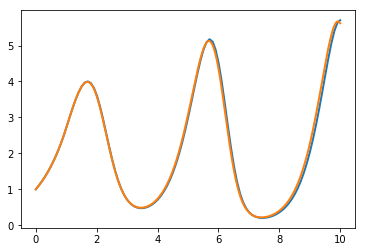

In [8]:
#изображение на одном графике решения tracer-ом и библиотечной функцией
import matplotlib.pyplot as plt
import numpy as np

plt.plot(time, result_x[10], lw=2)
from ddeint import ddeint

k = 2
h = 1
r = 1

model = lambda Y,t, k,h,r :  r * (k - ( Y(t-h))) * Y(t)
g = lambda t: 1 # history before t=0
tt = np.linspace(0,10,10000)
yy = ddeint(model, g, tt, fargs=(k, h, r)) # K=0.1, d=5, r=1
plt.plot(tt, yy, lw=2)
plt.show()
